In [1]:
#!pip install keras==2.3.1  
#%tensorflow_version 1.x
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from numpy import asarray
from pathlib import Path
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten,BatchNormalization,Dense,Dropout
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.utils import np_utils,to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.regularizers import l2
from numpy import load
from numpy import savez_compressed
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import svm
import seaborn as sn
from google.colab import drive
import random

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
directory = '/content/drive/My Drive/CMPE255/src/'

In [0]:
fer_data=pd.read_csv(directory+'Data/fer2013.csv',delimiter=',')

In [0]:
def load_data(fer_data):
    train_images = []
    test_images = []
    train_labels = []
    test_labels = []
    for index,row in fer_data.iterrows():
        pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
        img=pixels.reshape((48,48))
        if row['Usage'] == 'Training':
          train_labels.append(row['emotion'])
          train_images.append(img)
        else :
          test_labels.append(row['emotion'])
          test_images.append(img)
    return (train_images,test_images,train_labels,test_labels)

## Load the data from the CSV

In [6]:
%time X_train, X_test, y_train, y_test = load_data(fer_data)

CPU times: user 18.1 s, sys: 638 ms, total: 18.7 s
Wall time: 18.7 s


In [0]:
def plot_images(data,label):
  emotion = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happy', 4 :'Sad', 5 : 'Surprise', 6 : 'Neutral'}
  f, axarr = plt.subplots(2,2,constrained_layout=True)
  axarr[0,0].imshow(data[0])
  axarr[0,0].set_title(emotion[label[0]])
  axarr[0,1].imshow(data[1])
  axarr[0,1].set_title(emotion[label[1]])
  axarr[1,0].imshow(data[2])
  axarr[1,0].set_title(emotion[label[2]])
  axarr[1,1].imshow(data[3])
  axarr[1,1].set_title(emotion[label[3]])

## Visualise four randomly selected images from the dataset

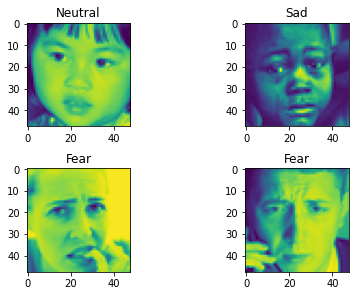

In [8]:
#randomly select f4 images
idx = np.random.choice(len(X_train),4,False)
plot_images([X_train[i] for i in idx] ,[y_train[i] for i in idx])

In [0]:
X_train = np.expand_dims(np.array(X_train),-1)
X_test = np.expand_dims(np.array(X_test),-1)

## Split the training data into training data and validation data

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,stratify=y_train, test_size=0.2, random_state=42)

In [11]:
print("Train Set : " ,len(y_train))
print("Test Set : " ,len(y_test))
print("Validation Set : " ,len(y_val))

Train Set :  22967
Test Set :  7178
Validation Set :  5742


In [0]:
def plot_bar(data):
    label = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
    index = np.arange(len(label))
    plt.bar(index, data)
    plt.xlabel('Emotion', fontsize=15)
    plt.ylabel('No of samples', fontsize=15)
    plt.xticks(index, label, fontsize=15, rotation=30)
    plt.show()

## Plot the count of images belonging to each class

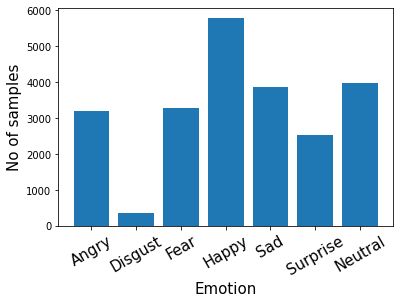

In [13]:
plot_bar(np.bincount(y_train))
y_train = to_categorical(y_train)

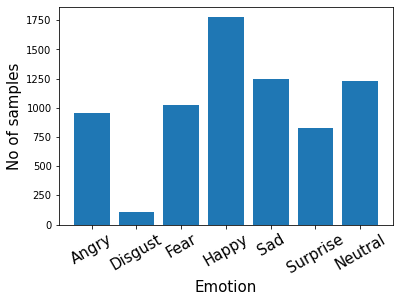

In [14]:
plot_bar(np.bincount(y_test))
y_test = to_categorical(y_test)

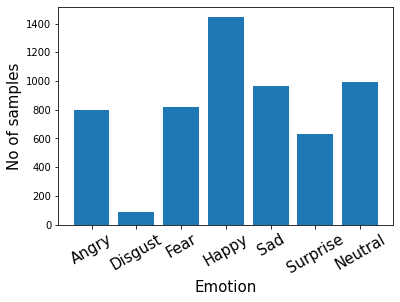

In [15]:
plot_bar(np.bincount(y_val))
y_val = to_categorical(y_val)

## Build the Convolutional Neural Network

In [16]:
img_width=48
img_height=48
num_classes=7

# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 1), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [0]:
# checkpoint
filepath= directory+"/Models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10,restore_best_weights=True)
callbacks_list = [checkpoint,earlystop]

## Train the model

In [18]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32,callbacks=callbacks_list)

Train on 22967 samples, validate on 5742 samples
Epoch 1/25
22967/22967 [==============================] - 11s 500us/step - loss: 2318773.0211 - accuracy: 0.2497 - val_loss: 1.8108 - val_accuracy: 0.2513

Epoch 00001: val_accuracy improved from -inf to 0.25131, saving model to /content/drive/My Drive/CMPE255/src//Models/weights-improvement-01-0.25.hdf5
Epoch 2/25
22967/22967 [==============================] - 5s 224us/step - loss: 1.8106 - accuracy: 0.2513 - val_loss: 1.8098 - val_accuracy: 0.2513

Epoch 00002: val_accuracy did not improve from 0.25131
Epoch 3/25
22967/22967 [==============================] - 5s 225us/step - loss: 1.8101 - accuracy: 0.2513 - val_loss: 1.8101 - val_accuracy: 0.2513

Epoch 00003: val_accuracy did not improve from 0.25131
Epoch 4/25
22967/22967 [==============================] - 5s 225us/step - loss: 1.8101 - accuracy: 0.2513 - val_loss: 1.8097 - val_accuracy: 0.2513

Epoch 00004: val_accuracy did not improve from 0.25131
Epoch 5/25
22967/22967 [=========

## Evaluate the model on test data

In [19]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 24.71%


In [0]:
y_pred = model.predict_classes(X_test)
matrix = confusion_matrix(np.argmax(y_test, axis=1),y_pred,normalize='true')

## Plot the confusion matrix

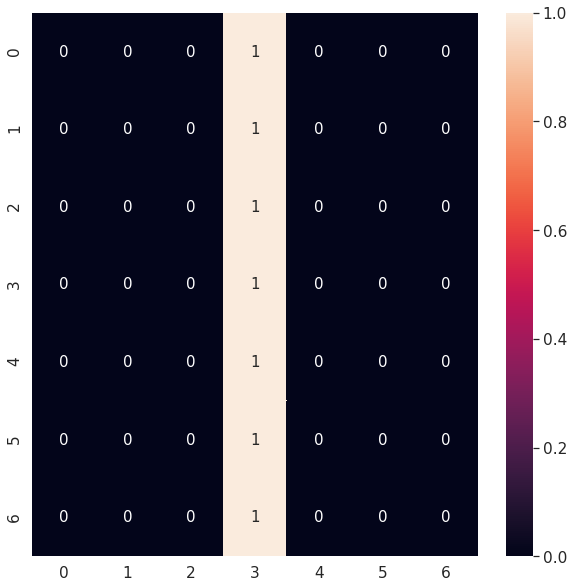

In [21]:
df_cm = pd.DataFrame(matrix,range(matrix.shape[0]),range(matrix.shape[1]))
plt.figure(figsize = (10,10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15})